In [1]:
import torch
from torch import nn

In [38]:
class MyBlockModel(nn.Module):

    def __init__(self, num_classes=2, init_weights=True, batch_norm=False):
        super(MyBlockModel, self).__init__()
        #cfgs = [16, 'M', 32, 'M'] #下面层数更多的网络同样的训练轮次和动态学习率比这个错误率更低
        cfgs = [16, 16, 'M', 32, 32, 'M', 32, 32, 'M']
        layers = []
        in_channels = 3
        for v in cfgs:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(32 * 7 * 7, 256),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, 256), #多加了这一层的作用感觉是训练轮次和损失的曲线更平滑了
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(256, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [39]:
from fastai.vision import *
from fastai.metrics import error_rate

In [40]:
path = Path('../../data/mnist')

In [41]:
path.ls()

[PosixPath('../../data/mnist/valid'),
 PosixPath('../../data/mnist/.DS_Store'),
 PosixPath('../../data/mnist/trainingSet'),
 PosixPath('../../data/mnist/models'),
 PosixPath('../../data/mnist/train'),
 PosixPath('../../data/mnist/testSet'),
 PosixPath('../../data/mnist/testSample')]

In [42]:
tfms = get_transforms(do_flip=False)

In [43]:
data = (ImageList.from_folder(path)
       .split_by_folder(train='train', valid='valid')
       .label_from_folder()
       .transform(tfms)
       .databunch(bs=16, num_workers=0))

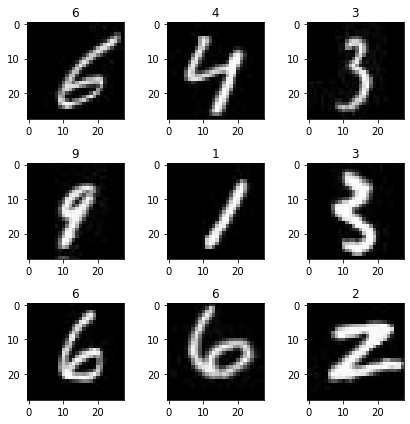

In [44]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [45]:
def Block(pretrained=False, batch_norm=True, **kwargs):
    model = MyBlockModel(batch_norm=batch_norm, **kwargs)
    return model

In [46]:
learner = cnn_learner(data, Block, metrics=error_rate)

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


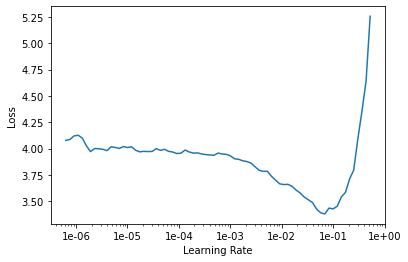

In [47]:
learner.lr_find()
learner.recorder.plot()

In [48]:
learner.fit_one_cycle(8, slice(2e-2, 5e-2))

epoch,train_loss,valid_loss,error_rate,time
0,2.761014,2.629330,0.611667,00:06
1,2.480038,1.433779,0.440000,00:06
2,2.250682,1.476260,0.393333,00:06
3,1.939116,1.932255,0.440000,00:06
4,1.813978,1.015196,0.280000,00:06
5,1.233600,0.704213,0.216667,00:07
6,0.945199,0.513655,0.160000,00:06
7,0.791811,0.518430,0.155000,00:06


In [49]:
learner.fit_one_cycle(8, slice(2e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.814942,0.572263,0.161667,00:06
1,0.977054,0.522187,0.140000,00:06
2,1.108582,0.636896,0.175000,00:06
3,1.043615,0.543374,0.183333,00:06
4,0.932639,0.529635,0.173333,00:06
5,0.841027,0.419567,0.125000,00:06
6,0.753651,0.427772,0.136667,00:06
7,0.717515,0.420135,0.136667,00:06


In [50]:
learner.save('custom-model')

# 总结

In [27]:
import torchsummary
torchsummary.summary(learner.model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             448
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
 AdaptiveMaxPool2d-9             [-1, 32, 1, 1]               0
AdaptiveAvgPool2d-10             [-1, 32, 1, 1]               0
AdaptiveConcatPool2d-11             [-1, 64, 1, 1]               0
          Flatten-12                   [-1, 64]               0
      BatchNorm1d-13                   [-1, 64]             128
          Dropout-14                

    第一层 参数 (ch*3*3)*16+16 = 3*3*3*16+16 = 448